# ***Assignment 1.2 - CAVI***
Consider the model defined by Equation (10.21)-(10-23) in Bishop, for which DGM is presented below:

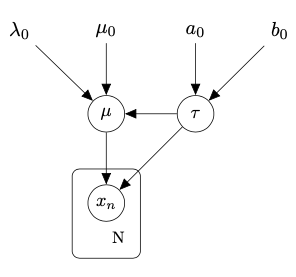

### ***Question 1.2.7:***

Implement a function that generates data points for the given model.

In [134]:
import numpy as np
def generate_data(mu, tau, N):
  # Insert your code here
  D = np.random.normal(mu, 1/tau, N)
  return D


Set μ = 1, τ = 0.5 and generate datasets with size N=10,100,1000. Plot the histogram for each of 3
datasets you generated.



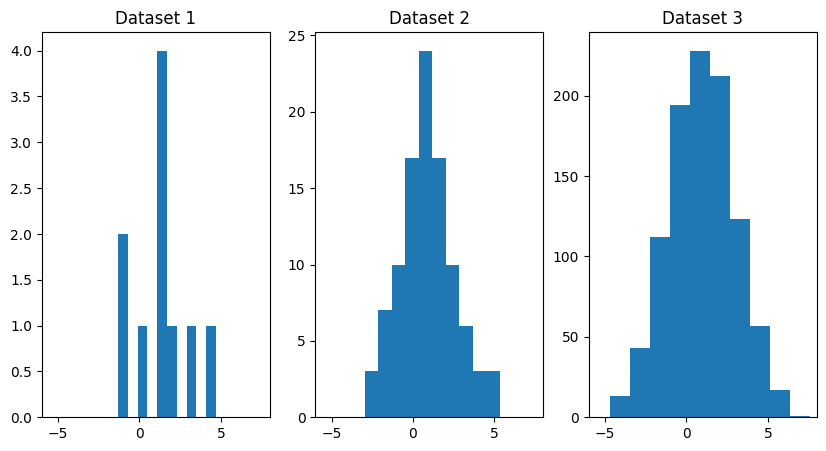

In [135]:
import matplotlib.pyplot as plt
mu = 1
tau = 0.5

dataset_1 = generate_data(mu, tau, 10)
dataset_2 = generate_data(mu, tau, 100)
dataset_3 = generate_data(mu, tau, 1000)

# Visulaize the datasets via histograms
# Insert your code here
plt.figure(figsize=[10, 5])
plt.subplot(1,3,1)
plt.xlim([-6,8])
plt.hist(dataset_1)
plt.title("Dataset 1")
plt.subplot(1,3,2)
plt.hist(dataset_2)
plt.xlim([-6,8])
plt.title("Dataset 2")
plt.subplot(1,3,3)
plt.hist(dataset_3)
plt.title("Dataset 3")
plt.xlim([-6,8])
plt.show()

### ***Question 1.2.8:***

Find ML estimates of the variables μ and τ

In [136]:
def ML_est(data, a_0, b_0, mu_0, lambda_0):
  # insert your code
  N = np.shape(data)[0]
  sum_xn = np.sum(data)
  mu_ml = (lambda_0 * mu_0 + sum_xn) / (N + lambda_0)
  tau_ml = ((N-3)/2 + a_0) / (1/2 * np.sum((data - mu_ml)**2) + lambda_0/2 * (mu_ml - mu_0)**2 + b_0)
  return mu_ml, tau_ml

### ***Question 1.2.9:***

What is the exact posterior? First derive it in closed form, and then implement a function that computes it for the given parameters:


In [137]:
def compute_exact_posterior(D, a_0, b_0, mu_0, lambda_0):
  # your implementation
  N = np.shape(D)[0]
  a_0_prime = N/2 + a_0
  b_0_prime = b_0 + 1/2 * (np.sum(D**2) + lambda_0 * mu_0**2) - 1/2 * (mu_0 * lambda_0 + np.sum(D))**2 / (N + lambda_0)
  mu_0_prime = (lambda_0 * mu_0 + np.sum(D)) / (N + lambda_0)
  lambda_0_prime = N + lambda_0
  exact_post_dist_parameters = [a_0_prime, b_0_prime, mu_0_prime, lambda_0_prime]
  return exact_post_dist_parameters

### ***Question 1.2.10:***
You will implement the VI algorithm for the variational distribution in Equation (10.24) in Bishop. Start with introducing the prior parameters:

In [138]:
# prior parameters
mu_0 = 1
lambda_0 = 4
a_0 = 0.5
b_0 = 1

Continue with a helper function that computes ELBO:


In [139]:
from scipy.special import digamma, gamma
sq2 = np.square
def compute_elbo (D, a_0, b_0, mu_0, lambda_0, a_N , b_N, mu_N, lambda_N):
  N = D.shape[0]
  # given the prior and posterior parameters together with the data,
  # compute ELBO here
  return ((N-3)/2 + a_0 + a_N)*(digamma(a_N) - np.log(b_N)) -0.5 * np.log(lambda_N) + lambda_N*sq2(mu_N) + a_N*(np.log(b_N)-1)-np.log(gamma(a_N))     -0.5*a_N/b_N * ( (N+lambda_0)/lambda_N  - (N+lambda_0)*sq2(mu_N) - 2*mu_N * (lambda_0*mu_0 + np.sum(D, axis=0)) + lambda_0*sq2(mu_0) + 2*b_0 + np.sum(sq2(D), axis=0))
   # +f(a_0, b_0, lambda_0, D)


Now, implement the CAVI algorithm:

In [140]:
def CAVI_updates(D, a_0, b_0, mu_0, lambda_0, a_N , b_N, mu_N, lambda_N):
  N = D.shape[0]
  mu_N = 1/(N+lambda_0)*(lambda_0*mu_0 + np.sum(D, axis=0))
  lambda_N = (N+lambda_0)*a_N/b_N
  a_N = (N+1)/2 + a_0
  b_N = b_0 +0.5*((N+lambda_0)/lambda_N + (N+lambda_0)*mu_N**2 + lambda_0*mu_0**2 + np.sum(sq2(D), axis=0) - 2*mu_0*(lambda_0*mu_N + np.sum(D, axis=0)))
  return mu_N, lambda_N, a_N, b_N
  
def CAVI(D, a_0, b_0, mu_0, lambda_0):

  # make an initial guess for the expected value of tau
  initial_guess_exp_tau = a_0 / b_0 * 0.95
  threshold = 0.01
  max_iters = 1000
  step_size = 0.1

  N = D.shape[0]
  mu_N = (1/(N+lambda_0)*(lambda_0*mu_0 + np.sum(D, axis=0)))
  lambda_N = (N+lambda_0)*initial_guess_exp_tau
  a_N = (N+1)/2 + a_0
  b_N = b_0 +0.5*((N+lambda_0)/lambda_N + (N+lambda_0)*sq2(mu_N) + lambda_0*sq2(mu_0) + np.sum(sq2(D), axis=0) - 2*mu_0*(lambda_0*mu_N + np.sum(D, axis=0)))

  mu_Ns = [mu_0]
  lambda_Ns = [lambda_0]
  a_Ns = [a_0]
  b_Ns = [b_0]

  mu_Ns.append(mu_Ns[-1]+step_size*(mu_N - mu_Ns[-1]))
  lambda_Ns.append(lambda_Ns[-1]+step_size*(lambda_N - lambda_Ns[-1]))
  a_Ns.append(a_Ns[-1]+step_size*(a_N - a_Ns[-1]))
  b_Ns.append(b_Ns[-1]+step_size*(b_N - b_Ns[-1]))

  elbo_0 = compute_elbo(D, a_0, b_0, mu_0, lambda_0, a_Ns[-1] , b_Ns[-1], mu_Ns[-1], lambda_Ns[-1])
  elbos = [elbo_0, elbo_0*(1+threshold*3)]
  i = 1

  while elbos[-1] / elbos[-2] - 1 >= threshold and i < max_iters:
    mu_N, lambda_N, a_N, b_N = CAVI_updates(D, a_0, b_0, mu_0, lambda_0, a_N , b_N, mu_N, lambda_N)
    
    mu_Ns.append(mu_Ns[-1]+step_size*(mu_N - mu_Ns[-1]))
    lambda_Ns.append(lambda_Ns[-1]+step_size*(lambda_N - lambda_Ns[-1]))
    a_Ns.append(a_Ns[-1]+step_size*(a_N - a_Ns[-1]))
    b_Ns.append(b_Ns[-1]+step_size*(b_N - b_Ns[-1]))

    elbos.append(compute_elbo(D, a_0, b_0, mu_0, lambda_0, a_Ns[-1] , b_Ns[-1], mu_Ns[-1], lambda_Ns[-1]))

    if i == 1:
      elbos[1] = elbos[0]
    i += 1
  # CAVI iterations ...
    # save ELBO for each iteration, plot them afterwards to show convergence

  return a_Ns, b_Ns, mu_Ns, lambda_Ns, elbos

Run the VI algorithm on the datasets. Compare the inferred variational
distribution with the exact posterior and the ML estimate. Visualize the results and discuss your
findings.


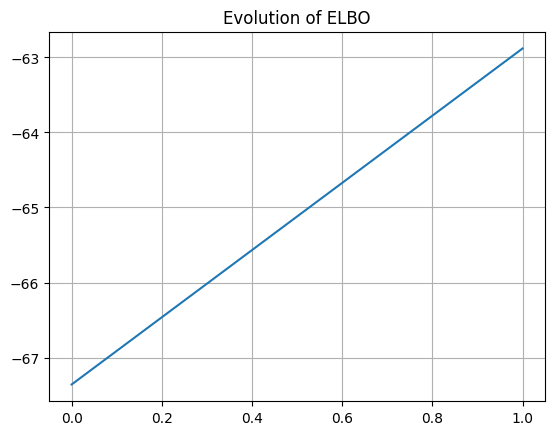

In [141]:
# Insert your main code here
# Example flow for dataset_2:
mu_ml, tau_ml = ML_est(dataset_2, a_0, b_0, mu_0, lambda_0)
a_N, b_N, mu_N, lambda_N, elbos = CAVI(dataset_2, a_0, b_0, mu_0, lambda_0)


plt.plot(elbos[1:])
plt.grid(True)
plt.title("Evolution of ELBO")
plt.show()
# exact_post_dist_param = compute_exact_posterior(dataset_2, a_0, b_0, mu_0, lambda_0)

  ##  compare exact_post_dist with the CAVI result ( = q(a_N, b_N, mu_N, lambda_N) ) using for ex. contour plots, show also ML estimate on this plot


